## Install dependencies

In [40]:
!pip install optuna joblib xgboost ta vnstock

In [26]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features

In [28]:
import matplotlib.pyplot as plt
import matplotlib

## Variables

In [29]:
current_storage = os.path.join("d:", "data")
vn30f_storage = os.path.join(current_storage, 'vn30f')

In [30]:
start_time = 0
now_time = 9999999999
symbol = 'VN30F1M'
rolling_window = 1 # Số phút muốn dự đoán tiếp theo

In [31]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "btc1-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

## Formulas

In [32]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [33]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [34]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [35]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 24)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [36]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [37]:
def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [38]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)

    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)

    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

## Get data

In [39]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution=1&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

In [41]:
df = get_vn30f(start_time, now_time, symbol)

===> Data VN30F1M from 1970-01-01 07:00:00 to 2286-11-21 00:46:39 has been appended 


In [51]:
df

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
323208,2024-06-19 14:27:00,1316.1,1317.3,1316.0,1316.5,2139
323209,2024-06-19 14:28:00,1316.0,1316.4,1315.6,1315.7,1588
323210,2024-06-19 14:29:00,1314.9,1315.4,1314.3,1314.5,3390
323211,2024-06-19 14:30:00,1315.1,1315.1,1315.1,1315.1,371


Fill missing data

In [43]:
from vnstock import stock_historical_data
df2 = stock_historical_data("VN30F1M", "2023-04-01", "2023-07-31", "3", 'derivative')
df2


The 'end_date' value in the report should be no more than 90 days from today for all resolutions shorter than 1 day. 



,time,open,high,low,close,volume,ticker
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331,VN30F1M
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257,VN30F1M
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101,VN30F1M
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891,VN30F1M
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498,VN30F1M
...,...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733,VN30F1M
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276,VN30F1M
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975,VN30F1M
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195,VN30F1M


In [48]:
temp = df2.drop(columns=['ticker'])
temp

,time,open,high,low,close,volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498
...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195


In [52]:
temp['time'] = pd.to_datetime(temp['time'])


morning_start = pd.Timestamp('09:00:00').time()
morning_end = pd.Timestamp('11:30:00').time()
afternoon_start = pd.Timestamp('13:00:00').time()
afternoon_end = pd.Timestamp('14:30:00').time()
ATC= pd.Timestamp('14:45:00').time()

time_points = []
current_time = morning_start

while current_time <= morning_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

current_time = afternoon_start
while current_time <= afternoon_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()
current_time= ATC
while current_time == ATC:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

temp = temp.set_index('time')
df_resampled = temp.resample('1T').first().reindex(pd.date_range(start=temp.index[0], end=temp.index[-1], freq='1T')).ffill()

df_resampled = df_resampled.reset_index().rename(columns={'index': 'time'})
temp = temp.reset_index().rename(columns={'index': 'time'})

df_resampled = df_resampled[df_resampled['time'].dt.time.isin(time_points)]
df_resampled  =df_resampled .rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

df_resampled


,Date,Open,High,Low,Close,Volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331.0
1,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,10331.0
2,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,10331.0
3,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257.0
4,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,4257.0
...,...,...,...,...,...,...
171687,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975.0
171688,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,6975.0
171689,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,6975.0
171690,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


In [53]:

combined_data = pd.merge(df, df_resampled, on='Date', how='outer', suffixes=('', '_data1'))

for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    combined_data[column].fillna(combined_data[f'{column}_data1'], inplace=True)

combined_data.drop(columns=[f'{column}_data1' for column in ['Open', 'High', 'Low', 'Close', 'Volume']], inplace=True)


combined_data.sort_values('Date', inplace=True)

combined_data.reset_index(drop=True, inplace=True)

In [54]:
combined_data

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...
352125,2024-06-19 14:27:00,1316.1,1317.3,1316.0,1316.5,2139.0
352126,2024-06-19 14:28:00,1316.0,1316.4,1315.6,1315.7,1588.0
352127,2024-06-19 14:29:00,1314.9,1315.4,1314.3,1314.5,3390.0
352128,2024-06-19 14:30:00,1315.1,1315.1,1315.1,1315.1,371.0


In [55]:
data=combined_data

In [60]:
df[
    (df['Date'] >= '2023-04-01') & (df['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-05-31 09:00:00,1067.7,1067.7,1066.8,1067.3,1860
278508,2023-05-31 09:01:00,1067.2,1067.3,1067.1,1067.2,641
278509,2023-05-31 09:02:00,1067.2,1068.1,1067.1,1068.1,724
278510,2023-05-31 09:03:00,1067.9,1068.1,1067.9,1068.0,428
278511,2023-05-31 09:04:00,1068.0,1068.1,1068.0,1068.1,312
...,...,...,...,...,...,...
278745,2023-05-31 14:27:00,1063.0,1063.0,1062.1,1062.2,1400
278746,2023-05-31 14:28:00,1062.7,1062.8,1062.3,1062.7,1022
278747,2023-05-31 14:29:00,1062.7,1063.0,1062.0,1062.6,2209
278748,2023-05-31 14:30:00,1062.2,1062.2,1062.2,1062.2,22


In [61]:
data[
    (data['Date'] >= '2023-04-01') & (data['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331.0
278508,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,10331.0
278509,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,10331.0
278510,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257.0
278511,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,4257.0
...,...,...,...,...,...,...
307662,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975.0
307663,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,6975.0
307664,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,6975.0
307665,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


## Preprocess

In [ ]:
from scipy.stats.mstats import winsorize
# Áp dụng Winsorization
data['Close'] = winsorize(data['Close'], limits=[0.05, 0.05])

In [ ]:
def process_data(data):
    data.set_index('Date', inplace =True)
    data.columns = ['Open','High','Low','Close','Volume']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]

    data = data[~data.index.duplicated(keep='first')] # Handling duplicate
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values
    # data_model.columns = ['Date','time','Close']

    return data_model

In [ ]:
data = process_data(data)

In [ ]:
data

,Date,time,Open,High,Low,Close,Volume
0,2018-08-13,09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...,...
345255,2024-06-11,14:27:00,1309.7,1309.8,1309.4,1309.8,201.0
345256,2024-06-11,14:28:00,1309.7,1309.8,1309.4,1309.8,201.0
345257,2024-06-11,14:29:00,1309.7,1309.8,1309.4,1309.8,201.0
345258,2024-06-11,14:30:00,1309.7,1309.8,1309.4,1309.8,201.0


## Create features

In [ ]:
def z_score_rolling(series, window=30):
    """Tính Z-score rolling"""
    mean = series.rolling(window).mean()
    std = series.rolling(window).std(ddof=0)
    z_score = (series - mean) / std
    return z_score

def generate_features(data, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """
    df = data.copy()
    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_Signal'] = macd['MACDs_12_26_9']
    df['MACD_Hist'] = macd['MACDh_12_26_9']

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch['STOCHk_14_3_3']
    df['Stoch_D'] = stoch['STOCHd_14_3_3']

    # ATR
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Z-score rolling
    df['Z_Score_Rolling'] = z_score_rolling(df['Close'], window=30)

    # Percent Change 5 minutes
    df['Trend_5min'] = df['Close'].pct_change(periods=5)

    # Rolling Standard Deviation 30 minutes
    df['Std_Rolling_30min'] = df['Close'].rolling(window=30).std()

    # Difference between Close and 30 minutes Moving Average
    ma_30min = df['Close'].rolling(window=30).mean()
    df['Close_Minus_MA_30min'] = df['Close'] - ma_30min

    # Simple Moving Average 10 minutes
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    df_ta = df.copy()
    df_ta.ta.strategy('all')

    cols_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'time']
    df_ta = df_ta.drop(columns=cols_to_drop, errors='ignore')

    # Concatenate original dataframe with features from pandas-ta
    df = pd.concat([df, df_ta], axis=1)

    # Replace infinite values and fill NaN values with 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    df2 = data.copy()
    df2 = add_all_ta_features(df2, open="Open", high="High", low="Low", close="Close", volume="Volume")
    df2 = df2.drop(columns=['Date','time', 'Open','High','Low','Close','Volume'])

    df3 = pd.concat([df, df2], axis=1)

    return df3

In [ ]:
data  = generate_features(data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Thêm các feature khác, ví dụ giá vàng (xem xét phù hợp với thời gian trong data)

# Add Predict Features

In [ ]:
data['Return'] = (data['Close'].shift(-rolling_window) - data['Close'])/data['Close']
data = data.fillna(0)
data = data.drop(index=0)
data

,Date,time,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,Trend_5min,Std_Rolling_30min,Close_Minus_MA_30min,SMA_10,Return
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0,-975.000000,9.750000e+02,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,942.900000,0.000424
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0,-755.000000,1.195000e+03,0.0,...,0.000000,0.000000,0.021211,0.021209,0.0,0.0,0.141421,0.100000,943.000000,-0.000106
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0,-674.333333,1.316000e+03,0.0,...,0.000000,0.000000,0.042413,0.042404,0.0,0.0,0.305505,0.333333,943.166667,-0.000318
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0,-539.333333,1.181000e+03,0.0,...,0.000000,0.000000,-0.010599,-0.010599,0.0,0.0,0.275379,0.175000,943.225000,-0.000106
5,2018-08-13,09:05:00,943.1,943.1,942.9,943.0,343.0,-539.333333,8.200000e+02,0.0,...,0.000000,0.000000,-0.031800,-0.031805,0.0,0.0,0.244949,-0.100000,943.200000,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345255,2024-06-11,14:27:00,1309.7,1309.8,1309.4,1309.8,201.0,0.000000,4.233462e+08,1.0,...,0.000396,1309.888426,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1309.800000,0.000000
345256,2024-06-11,14:28:00,1309.7,1309.8,1309.4,1309.8,201.0,0.000000,4.233464e+08,1.0,...,0.000367,1309.888058,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1309.800000,0.000000
345257,2024-06-11,14:29:00,1309.7,1309.8,1309.4,1309.8,201.0,0.000000,4.233466e+08,1.0,...,0.000340,1309.887691,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1309.800000,0.000000
345258,2024-06-11,14:30:00,1309.7,1309.8,1309.4,1309.8,201.0,0.000000,4.233468e+08,1.0,...,0.000315,1309.887326,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1309.800000,0.000000


# Feature Engineering

In [ ]:
def drop_high_corr_columns(df, threshold=0.6):
    ohlcv_columns = {'Date','time', 'Open','High','Low','Close','Volume'}

     # Identify non-OHLCV and non-date/time columns
    non_corr_columns = [col for col in df.columns if col not in ohlcv_columns]

    # Compute the correlation matrix only for non-OHLCV and non-date/time columns
    corr_matrix = df[non_corr_columns].corr().abs()

    # Create a set to keep track of columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # If the correlation is higher than the threshold, mark the column with the higher index to drop
                col_to_drop = corr_matrix.columns[j]
                if col_to_drop not in ohlcv_columns:
                    to_drop.add(col_to_drop)

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=to_drop)
    return df_dropped

data = drop_high_corr_columns(data)

In [ ]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price):

    # Select features based on Optuna's suggestions
    selected_features = []
    for col in X_train.columns:
        if trial.suggest_categorical(col, [0, 1]):
            selected_features.append(col)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    # trade_threshold = trial.suggest_float('trade_threshold', 0.008, 0.08, step=0.0004)
    trade_threshold  = 0.0005

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = xgb.XGBRegressor()
    model.fit(X_train_selected, y_train)

    y_pred_train = model.predict(X_train_selected)
    y_pred_valid = model.predict(X_valid_selected)

    _, pos_is, _, sharpe_is = sharpe_for_vn30f(y_pred_train, y_price[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, pos_os, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_price[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print('Trade times in sample:',len(pos_is[pos_is != 0]), 'Trade times out sample:',len(pos_os[pos_os != 0]))

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

X_train, X_valid, y_train, y_valid, train_data = split_optuna_data(data)

In [ ]:
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function
study = optuna.create_study(directions=['maximize', 'minimize'])
unique_trials = 50

while unique_trials > len(set(str(t.params) for t in study.trials)):
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
    study.trials_dataframe().sort_values('values_0').to_csv('feature_trials.csv')
    joblib.dump(study, 'abmodel.pkl')

trials = study.trials
trials.sort(key=lambda trial: trial.values, reverse=True)
study.trials_dataframe().sort_values('values_0', ascending=False).duplicated().sum()

"""## Checking part for fixing bug"""
df =study.trials_dataframe()

# df.to_csv('save_trials.csv')

[I 2024-06-11 03:24:24,452] A new study created in memory with name: no-name-f6fffc02-a13d-4436-afa3-53eef26866d7


A new study created in memory with name: no-name-f6fffc02-a13d-4436-afa3-53eef26866d7
A new study created in memory with name: no-name-f6fffc02-a13d-4436-afa3-53eef26866d7
A new study created in memory with name: no-name-f6fffc02-a13d-4436-afa3-53eef26866d7
A new study created in memory with name: no-name-f6fffc02-a13d-4436-afa3-53eef26866d7


[I 2024-06-11 03:24:27,795] Trial 0 finished with values: [-0.13672183746235242, 6.644453127361338] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114188 Trade times out sample: 114528
Trial 0 finished with values: [-0.13672183746235242, 6.644453127361338] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 0 finished with values: [-0.13672183746235242, 6.644453127361338] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:29,396] Trial 1 finished with values: [-0.09948235318848082, 9.317842347589623] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114249 Trade times out sample: 114801
Trial 1 finished with values: [-0.09948235318848082, 9.317842347589623] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 1 finished with values: [-0.09948235318848082, 9.317842347589623] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:24:31,075] Trial 2 finished with values: [0.055143210508336815, 18.064397018861577] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114365 Trade times out sample: 114527
Trial 2 finished with values: [0.055143210508336815, 18.064397018861577] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 2 finished with values: [0.055143210508336815, 18.064397018861577] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:24:32,620] Trial 3 finished with values: [-0.5855815869145142, 0.8075991585593847] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114242 Trade times out sample: 114881
Trial 3 finished with values: [-0.5855815869145142, 0.8075991585593847] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 3 finished with values: [-0.5855815869145142, 0.8075991585593847] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:24:34,192] Trial 4 finished with values: [-0.0620616374940927, 17.343485931431797] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114253 Trade times out sample: 114595
Trial 4 finished with values: [-0.0620616374940927, 17.343485931431797] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 4 finished with values: [-0.0620616374940927, 17.343485931431797] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:24:35,750] Trial 5 finished with values: [0.14563962736220507, 5.4591766480276345] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 113881 Trade times out sample: 114792
Trial 5 finished with values: [0.14563962736220507, 5.4591766480276345] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 5 finished with values: [0.14563962736220507, 5.4591766480276345] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:38,082] Trial 6 finished with values: [-0.4862594578616598, 1.631957867677734] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114334 Trade times out sample: 114810
Trial 6 finished with values: [-0.4862594578616598, 1.631957867677734] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 6 finished with values: [-0.4862594578616598, 1.631957867677734] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_

[I 2024-06-11 03:24:40,862] Trial 7 finished with values: [-0.21683428447642927, 2.955514505318286] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114184 Trade times out sample: 114604
Trial 7 finished with values: [-0.21683428447642927, 2.955514505318286] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 7 finished with values: [-0.21683428447642927, 2.955514505318286] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:42,732] Trial 8 finished with values: [-0.23737060663504148, 5.079047277590964] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114492 Trade times out sample: 114869
Trial 8 finished with values: [-0.23737060663504148, 5.079047277590964] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 8 finished with values: [-0.23737060663504148, 5.079047277590964] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:44,308] Trial 9 finished with values: [-0.05847505294094918, 17.090760220468027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114436 Trade times out sample: 114802
Trial 9 finished with values: [-0.05847505294094918, 17.090760220468027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 9 finished with values: [-0.05847505294094918, 17.090760220468027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:24:45,686] Trial 10 finished with values: [-0.4107235205277478, 1.4873271515579916] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114937 Trade times out sample: 114859
Trial 10 finished with values: [-0.4107235205277478, 1.4873271515579916] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 10 finished with values: [-0.4107235205277478, 1.4873271515579916] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:24:47,454] Trial 11 finished with values: [-0.03750942506757538, 30.139948696189983] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114366 Trade times out sample: 114528
Trial 11 finished with values: [-0.03750942506757538, 30.139948696189983] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 11 finished with values: [-0.03750942506757538, 30.139948696189983] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:24:49,178] Trial 12 finished with values: [-0.1516308974289128, 6.8399156931675655] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114351 Trade times out sample: 114785
Trial 12 finished with values: [-0.1516308974289128, 6.8399156931675655] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 12 finished with values: [-0.1516308974289128, 6.8399156931675655] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:24:51,316] Trial 13 finished with values: [0.001361079794566757, 678.4514827110913] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 110948 Trade times out sample: 114033
Trial 13 finished with values: [0.001361079794566757, 678.4514827110913] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 13 finished with values: [0.001361079794566757, 678.4514827110913] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:24:54,582] Trial 14 finished with values: [-0.11869268870062101, 9.612051527375916] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114369 Trade times out sample: 114799
Trial 14 finished with values: [-0.11869268870062101, 9.612051527375916] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 14 finished with values: [-0.11869268870062101, 9.612051527375916] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:24:56,092] Trial 15 finished with values: [-0.1866325304988846, 6.469586437662389] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114373 Trade times out sample: 114858
Trial 15 finished with values: [-0.1866325304988846, 6.469586437662389] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 15 finished with values: [-0.1866325304988846, 6.469586437662389] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:57,825] Trial 16 finished with values: [-0.1734485456902279, 6.632447927146979] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 113377 Trade times out sample: 114572
Trial 16 finished with values: [-0.1734485456902279, 6.632447927146979] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 16 finished with values: [-0.1734485456902279, 6.632447927146979] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:24:59,530] Trial 17 finished with values: [-0.11034910456084168, 11.767351344276385] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 115082 Trade times out sample: 114802
Trial 17 finished with values: [-0.11034910456084168, 11.767351344276385] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 17 finished with values: [-0.11034910456084168, 11.767351344276385] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:25:01,166] Trial 18 finished with values: [0.2255964582851316, 3.6161847865168495] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114253 Trade times out sample: 114568
Trial 18 finished with values: [0.2255964582851316, 3.6161847865168495] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 18 finished with values: [0.2255964582851316, 3.6161847865168495] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:25:02,755] Trial 19 finished with values: [-0.05348393114390491, 14.83436756759768] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114365 Trade times out sample: 114724
Trial 19 finished with values: [-0.05348393114390491, 14.83436756759768] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 19 finished with values: [-0.05348393114390491, 14.83436756759768] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:06,376] Trial 20 finished with values: [-0.3875575021707464, 1.4798895955990488] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 110852 Trade times out sample: 114572
Trial 20 finished with values: [-0.3875575021707464, 1.4798895955990488] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 20 finished with values: [-0.3875575021707464, 1.4798895955990488] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:07,952] Trial 21 finished with values: [-0.3202038897527275, 2.3324322624449128] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 110733 Trade times out sample: 114572
Trial 21 finished with values: [-0.3202038897527275, 2.3324322624449128] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 21 finished with values: [-0.3202038897527275, 2.3324322624449128] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:09,694] Trial 22 finished with values: [-0.26307302168124963, 2.978024650266852] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114370 Trade times out sample: 114802
Trial 22 finished with values: [-0.26307302168124963, 2.978024650266852] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 22 finished with values: [-0.26307302168124963, 2.978024650266852] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:11,345] Trial 23 finished with values: [-0.09788229964147264, 9.443946549121048] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 104838 Trade times out sample: 114726
Trial 23 finished with values: [-0.09788229964147264, 9.443946549121048] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 23 finished with values: [-0.09788229964147264, 9.443946549121048] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:12,954] Trial 24 finished with values: [-0.2275829883871809, 4.778261081462176] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114366 Trade times out sample: 114688
Trial 24 finished with values: [-0.2275829883871809, 4.778261081462176] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 24 finished with values: [-0.2275829883871809, 4.778261081462176] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:25:14,367] Trial 25 finished with values: [0.029246943471190584, 21.855193637843605] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 111186 Trade times out sample: 114858
Trial 25 finished with values: [0.029246943471190584, 21.855193637843605] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 25 finished with values: [0.029246943471190584, 21.855193637843605] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:25:16,002] Trial 26 finished with values: [-0.6534916012962155, 0.5653596986586515] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114866 Trade times out sample: 114878
Trial 26 finished with values: [-0.6534916012962155, 0.5653596986586515] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 26 finished with values: [-0.6534916012962155, 0.5653596986586515] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:19,423] Trial 27 finished with values: [-0.25189749415372614, 1.4407153053524748] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 114349 Trade times out sample: 114858
Trial 27 finished with values: [-0.25189749415372614, 1.4407153053524748] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 27 finished with values: [-0.25189749415372614, 1.4407153053524748] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volat

[I 2024-06-11 03:25:21,184] Trial 28 finished with values: [-0.08957338590052864, 10.869584833629668] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114365 Trade times out sample: 114094
Trial 28 finished with values: [-0.08957338590052864, 10.869584833629668] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 28 finished with values: [-0.08957338590052864, 10.869584833629668] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volat

[I 2024-06-11 03:25:22,746] Trial 29 finished with values: [0.006169942233301605, 157.73561582789804] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 108991 Trade times out sample: 114855
Trial 29 finished with values: [0.006169942233301605, 157.73561582789804] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 29 finished with values: [0.006169942233301605, 157.73561582789804] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:25:24,253] Trial 30 finished with values: [-0.290742027956902, 2.7579205214220694] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 114492 Trade times out sample: 114695
Trial 30 finished with values: [-0.290742027956902, 2.7579205214220694] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 30 finished with values: [-0.290742027956902, 2.7579205214220694] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:25:25,744] Trial 31 finished with values: [0.00613250625852838, 166.6677345306576] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 114495 Trade times out sample: 114783
Trial 31 finished with values: [0.00613250625852838, 166.6677345306576] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 31 finished with values: [0.00613250625852838, 166.6677345306576] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:25:28,004] Trial 32 finished with values: [-0.19211293873184285, 4.030653130225256] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 104847 Trade times out sample: 114056
Trial 32 finished with values: [-0.19211293873184285, 4.030653130225256] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 32 finished with values: [-0.19211293873184285, 4.030653130225256] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:32,956] Trial 33 finished with values: [-0.4383213153044374, 1.9540324604256467] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114366 Trade times out sample: 114884
Trial 33 finished with values: [-0.4383213153044374, 1.9540324604256467] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 33 finished with values: [-0.4383213153044374, 1.9540324604256467] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:34,595] Trial 34 finished with values: [0.20219279750957111, 3.727847449762254] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114575 Trade times out sample: 114528
Trial 34 finished with values: [0.20219279750957111, 3.727847449762254] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 34 finished with values: [0.20219279750957111, 3.727847449762254] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:25:36,319] Trial 35 finished with values: [0.01384859635708388, 89.86875984749021] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 113916 Trade times out sample: 114794
Trial 35 finished with values: [0.01384859635708388, 89.86875984749021] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 35 finished with values: [0.01384859635708388, 89.86875984749021] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatilit

[I 2024-06-11 03:25:37,832] Trial 36 finished with values: [0.2953406775071881, 2.460864964797464] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 110841 Trade times out sample: 114595
Trial 36 finished with values: [0.2953406775071881, 2.460864964797464] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 36 finished with values: [0.2953406775071881, 2.460864964797464] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_

[I 2024-06-11 03:25:39,578] Trial 37 finished with values: [-0.39883771833029513, 1.682587491651086] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114377 Trade times out sample: 114865
Trial 37 finished with values: [-0.39883771833029513, 1.682587491651086] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 37 finished with values: [-0.39883771833029513, 1.682587491651086] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:41,201] Trial 38 finished with values: [-0.30518742238484603, 2.422348539441089] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114381 Trade times out sample: 114545
Trial 38 finished with values: [-0.30518742238484603, 2.422348539441089] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 38 finished with values: [-0.30518742238484603, 2.422348539441089] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:43,254] Trial 39 finished with values: [0.026527775545976184, 41.94045586728326] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114367 Trade times out sample: 114568
Trial 39 finished with values: [0.026527775545976184, 41.94045586728326] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 39 finished with values: [0.026527775545976184, 41.94045586728326] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:46,823] Trial 40 finished with values: [-0.18419329714625504, 5.102233352671672] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114363 Trade times out sample: 114801
Trial 40 finished with values: [-0.18419329714625504, 5.102233352671672] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 40 finished with values: [-0.18419329714625504, 5.102233352671672] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:48,535] Trial 41 finished with values: [-0.06414506856048932, 17.73326177592172] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 114492 Trade times out sample: 114528
Trial 41 finished with values: [-0.06414506856048932, 17.73326177592172] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 41 finished with values: [-0.06414506856048932, 17.73326177592172] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:49,958] Trial 42 finished with values: [-0.26242634947663496, 0.4825953140809329] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 109765 Trade times out sample: 104519
Trial 42 finished with values: [-0.26242634947663496, 0.4825953140809329] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 42 finished with values: [-0.26242634947663496, 0.4825953140809329] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:25:51,461] Trial 43 finished with values: [-0.2889036677733826, 2.4543529652865175] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 110966 Trade times out sample: 114097
Trial 43 finished with values: [-0.2889036677733826, 2.4543529652865175] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 43 finished with values: [-0.2889036677733826, 2.4543529652865175] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 0, 'volume_mfi': 1, 'volatil

[I 2024-06-11 03:25:53,104] Trial 44 finished with values: [0.03239125298219625, 28.17346817553971] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114883 Trade times out sample: 114799
Trial 44 finished with values: [0.03239125298219625, 28.17346817553971] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 1, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 44 finished with values: [0.03239125298219625, 28.17346817553971] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

[I 2024-06-11 03:25:54,880] Trial 45 finished with values: [0.07783023698927265, 14.569274259104288] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 114122 Trade times out sample: 114884
Trial 45 finished with values: [0.07783023698927265, 14.569274259104288] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 45 finished with values: [0.07783023698927265, 14.569274259104288] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:25:57,364] Trial 46 finished with values: [-0.36813624267349837, 2.2538704642724343] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 114366 Trade times out sample: 114793
Trial 46 finished with values: [-0.36813624267349837, 2.2538704642724343] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 46 finished with values: [-0.36813624267349837, 2.2538704642724343] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:26:00,105] Trial 47 finished with values: [-0.07237156434231237, 13.975332758956322] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114366 Trade times out sample: 114398
Trial 47 finished with values: [-0.07237156434231237, 13.975332758956322] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 47 finished with values: [-0.07237156434231237, 13.975332758956322] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volat

[I 2024-06-11 03:26:01,686] Trial 48 finished with values: [-0.17634967541058977, 4.166612195062989] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 113878 Trade times out sample: 114849
Trial 48 finished with values: [-0.17634967541058977, 4.166612195062989] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 1, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 0, 'trend_dpo': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 48 finished with values: [-0.17634967541058977, 4.166612195062989] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 0, 'volatil

[I 2024-06-11 03:26:03,388] Trial 49 finished with values: [0.5512951065041302, 0.4875043790370679] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 114121 Trade times out sample: 114813
Trial 49 finished with values: [0.5512951065041302, 0.4875043790370679] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 1, 'trend_dpo': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 49 finished with values: [0.5512951065041302, 0.4875043790370679] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_vwap': 1, 'volume_mfi': 1, 'volatilit

Retrieve Top PNL

In [ ]:
trials = study.trials

# Sort trials based on objective values
trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = trials[:100]

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for col in new_df_no_close_col.columns if trial.params[col] == 1]
  top_features_list.append(best_selected_features)

In [ ]:
top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

# ONC

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

In [ ]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

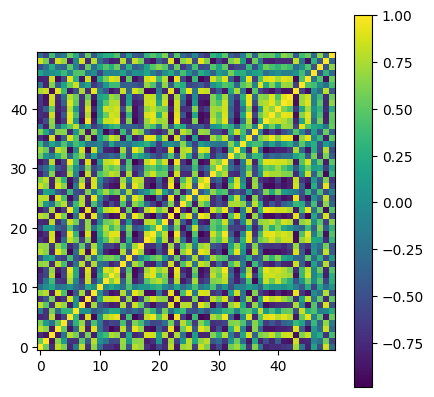

maxNumClusters25
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


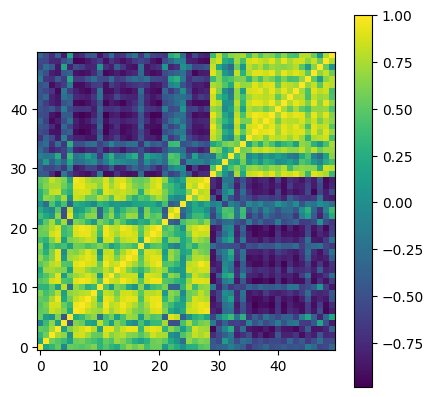

In [ ]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [ ]:
for cluster_number, cluster_indices in clstrsNew.items():
    print(f"Cluster {cluster_number}:")
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        trial_params = top_trials[idx].params
        print(f"- Trial {trial_number}: {trial_params}")

Cluster 0:
- Trial 18: {'volume_adi': 1, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_vwap': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 0, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0, 'trend_dpo': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}
- Trial 45: {'volume_adi': 0, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vwap': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index':

In [ ]:
import pandas as pd

cluster_frequencies = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_features = top_trials[idx].number
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1],  reverse=True)

    print(f"Cluster {cluster_number}:")
    top_features = sorted_frequency[:10]
    df = pd.DataFrame(top_features, columns=['Feature', 'Frequency'])
    print(df)


Cluster 0:
            Feature  Frequency
0   trend_macd_diff         20
1    volatility_kcw         19
2    trend_aroon_up         19
3         others_cr         19
4   volatility_bbli         18
5        volume_obv         18
6         volume_fi         18
7        trend_macd         17
8       volume_vwap         16
9  trend_mass_index         16
Cluster 1:
             Feature  Frequency
0          others_cr         15
1        volume_vwap         14
2          volume_em         14
3          others_dr         14
4          volume_fi         13
5    volatility_bbli         13
6  momentum_pvo_hist         13
7     volatility_bbw         13
8     volatility_kcp         13
9   trend_mass_index         12


In [ ]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [18, 45, 2, 25, 35, 29, 31, 13, 19, 41, 47, 28, 23, 17, 12, 40, 15, 32, 27, 22, 43, 30, 38, 21, 46, 37, 10, 6, 26]
Cluster 1: [49, 36, 34, 5, 44, 39, 11, 9, 4, 1, 14, 0, 16, 48, 7, 24, 8, 42, 20, 33, 3]


In [ ]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: ['trend_macd_diff', 'volatility_kcw', 'trend_aroon_up', 'others_cr', 'volatility_bbli', 'volume_obv', 'volume_fi', 'trend_macd', 'volume_vwap', 'trend_mass_index']
Top 10 features for Cluster 1: ['others_cr', 'volume_vwap', 'volume_em', 'others_dr', 'volume_fi', 'volatility_bbli', 'momentum_pvo_hist', 'volatility_bbw', 'volatility_kcp', 'trend_mass_index']


In [ ]:
top_10_features_per_cluster

[['trend_macd_diff',
  'volatility_kcw',
  'trend_aroon_up',
  'others_cr',
  'volatility_bbli',
  'volume_obv',
  'volume_fi',
  'trend_macd',
  'volume_vwap',
  'trend_mass_index'],
 ['others_cr',
  'volume_vwap',
  'volume_em',
  'others_dr',
  'volume_fi',
  'volatility_bbli',
  'momentum_pvo_hist',
  'volatility_bbw',
  'volatility_kcp',
  'trend_mass_index']]

In [ ]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [ ]:
selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.loc[:, item]
  selected_columns_cluster.append(selected_columns)

# Model selection

## Custom Early Stopping

In [ ]:
from xgboost import callback

In [ ]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [ ]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close):
    # Define the hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': 8000,  # does not matter, think of it as max epochs, and we stop the model based on early stopping, so any extremely high number works
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # can't comment, never played with that
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # you dont want to sample less than 50% of your data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),  # you dont want to sample less than 30% of your features pr boosting round
        }
    trade_threshold  = 0.0005

    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)

    # Train the model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, callbacks=[custom_early_stopping_instance])

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)


    pos, pnl, daily_pnl, sharpe_is = sharpe_for_vn30f(y_pred_train, y_close[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, _, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_close[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

In [ ]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['Return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize'])

    unique_trials = 10
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)

    # Retrieve all trials
    trials = study.trials

    # Sort trials based on objective values
    trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = trials[0].params
    best_params_list.append(params)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    model.save_model(f'best_in_cluster_{idx}.json')

[I 2024-06-11 03:27:22,792] A new study created in memory with name: no-name-c68d605a-3943-490e-9bdb-9d8940b2aa86


A new study created in memory with name: no-name-c68d605a-3943-490e-9bdb-9d8940b2aa86
A new study created in memory with name: no-name-c68d605a-3943-490e-9bdb-9d8940b2aa86
A new study created in memory with name: no-name-c68d605a-3943-490e-9bdb-9d8940b2aa86
A new study created in memory with name: no-name-c68d605a-3943-490e-9bdb-9d8940b2aa86


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:27:52,088] Trial 0 finished with values: [-0.3020677489992953, 5.625496982501509] and parameters: {'max_depth': 5, 'learning_rate': 0.083073013680005, 'min_child_weight': 2, 'subsample': 0.8457573269287564, 'colsample_bytree': 0.9957705257005827}. 


Trial 0 finished with values: [-0.3020677489992953, 5.625496982501509] and parameters: {'max_depth': 5, 'learning_rate': 0.083073013680005, 'min_child_weight': 2, 'subsample': 0.8457573269287564, 'colsample_bytree': 0.9957705257005827}. 
Trial 0 finished with values: [-0.3020677489992953, 5.625496982501509] and parameters: {'max_depth': 5, 'learning_rate': 0.083073013680005, 'min_child_weight': 2, 'subsample': 0.8457573269287564, 'colsample_bytree': 0.9957705257005827}. 
Trial 0 finished with values: [-0.3020677489992953, 5.625496982501509] and parameters: {'max_depth': 5, 'learning_rate': 0.083073013680005, 'min_child_weight': 2, 'subsample': 0.8457573269287564, 'colsample_bytree': 0.9957705257005827}. 
Trial 0 finished with values: [-0.3020677489992953, 5.625496982501509] and parameters: {'max_depth': 5, 'learning_rate': 0.083073013680005, 'min_child_weight': 2, 'subsample': 0.8457573269287564, 'colsample_bytree': 0.9957705257005827}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:28:24,192] Trial 1 finished with values: [-0.2848199290331501, 5.226430378937548] and parameters: {'max_depth': 6, 'learning_rate': 0.026725225159688955, 'min_child_weight': 5, 'subsample': 0.8700887891178806, 'colsample_bytree': 0.8984419996221633}. 


Trial 1 finished with values: [-0.2848199290331501, 5.226430378937548] and parameters: {'max_depth': 6, 'learning_rate': 0.026725225159688955, 'min_child_weight': 5, 'subsample': 0.8700887891178806, 'colsample_bytree': 0.8984419996221633}. 
Trial 1 finished with values: [-0.2848199290331501, 5.226430378937548] and parameters: {'max_depth': 6, 'learning_rate': 0.026725225159688955, 'min_child_weight': 5, 'subsample': 0.8700887891178806, 'colsample_bytree': 0.8984419996221633}. 
Trial 1 finished with values: [-0.2848199290331501, 5.226430378937548] and parameters: {'max_depth': 6, 'learning_rate': 0.026725225159688955, 'min_child_weight': 5, 'subsample': 0.8700887891178806, 'colsample_bytree': 0.8984419996221633}. 
Trial 1 finished with values: [-0.2848199290331501, 5.226430378937548] and parameters: {'max_depth': 6, 'learning_rate': 0.026725225159688955, 'min_child_weight': 5, 'subsample': 0.8700887891178806, 'colsample_bytree': 0.8984419996221633}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:28:58,910] Trial 2 finished with values: [-0.2798754073008475, 4.536155643710184] and parameters: {'max_depth': 4, 'learning_rate': 0.03147833419915812, 'min_child_weight': 5, 'subsample': 0.8591063966845048, 'colsample_bytree': 0.9002822976689684}. 


Trial 2 finished with values: [-0.2798754073008475, 4.536155643710184] and parameters: {'max_depth': 4, 'learning_rate': 0.03147833419915812, 'min_child_weight': 5, 'subsample': 0.8591063966845048, 'colsample_bytree': 0.9002822976689684}. 
Trial 2 finished with values: [-0.2798754073008475, 4.536155643710184] and parameters: {'max_depth': 4, 'learning_rate': 0.03147833419915812, 'min_child_weight': 5, 'subsample': 0.8591063966845048, 'colsample_bytree': 0.9002822976689684}. 
Trial 2 finished with values: [-0.2798754073008475, 4.536155643710184] and parameters: {'max_depth': 4, 'learning_rate': 0.03147833419915812, 'min_child_weight': 5, 'subsample': 0.8591063966845048, 'colsample_bytree': 0.9002822976689684}. 
Trial 2 finished with values: [-0.2798754073008475, 4.536155643710184] and parameters: {'max_depth': 4, 'learning_rate': 0.03147833419915812, 'min_child_weight': 5, 'subsample': 0.8591063966845048, 'colsample_bytree': 0.9002822976689684}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:29:45,107] Trial 3 finished with values: [-0.34010092648981916, 4.106132743213412] and parameters: {'max_depth': 3, 'learning_rate': 0.06321513158555642, 'min_child_weight': 8, 'subsample': 0.7269208021652797, 'colsample_bytree': 0.9732931698428238}. 


Trial 3 finished with values: [-0.34010092648981916, 4.106132743213412] and parameters: {'max_depth': 3, 'learning_rate': 0.06321513158555642, 'min_child_weight': 8, 'subsample': 0.7269208021652797, 'colsample_bytree': 0.9732931698428238}. 
Trial 3 finished with values: [-0.34010092648981916, 4.106132743213412] and parameters: {'max_depth': 3, 'learning_rate': 0.06321513158555642, 'min_child_weight': 8, 'subsample': 0.7269208021652797, 'colsample_bytree': 0.9732931698428238}. 
Trial 3 finished with values: [-0.34010092648981916, 4.106132743213412] and parameters: {'max_depth': 3, 'learning_rate': 0.06321513158555642, 'min_child_weight': 8, 'subsample': 0.7269208021652797, 'colsample_bytree': 0.9732931698428238}. 
Trial 3 finished with values: [-0.34010092648981916, 4.106132743213412] and parameters: {'max_depth': 3, 'learning_rate': 0.06321513158555642, 'min_child_weight': 8, 'subsample': 0.7269208021652797, 'colsample_bytree': 0.9732931698428238}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:30:14,479] Trial 4 finished with values: [0.06426308260018057, 33.43250115994543] and parameters: {'max_depth': 6, 'learning_rate': 0.09365915548262635, 'min_child_weight': 9, 'subsample': 0.8451914489368791, 'colsample_bytree': 0.9410885939157312}. 


Trial 4 finished with values: [0.06426308260018057, 33.43250115994543] and parameters: {'max_depth': 6, 'learning_rate': 0.09365915548262635, 'min_child_weight': 9, 'subsample': 0.8451914489368791, 'colsample_bytree': 0.9410885939157312}. 
Trial 4 finished with values: [0.06426308260018057, 33.43250115994543] and parameters: {'max_depth': 6, 'learning_rate': 0.09365915548262635, 'min_child_weight': 9, 'subsample': 0.8451914489368791, 'colsample_bytree': 0.9410885939157312}. 
Trial 4 finished with values: [0.06426308260018057, 33.43250115994543] and parameters: {'max_depth': 6, 'learning_rate': 0.09365915548262635, 'min_child_weight': 9, 'subsample': 0.8451914489368791, 'colsample_bytree': 0.9410885939157312}. 
Trial 4 finished with values: [0.06426308260018057, 33.43250115994543] and parameters: {'max_depth': 6, 'learning_rate': 0.09365915548262635, 'min_child_weight': 9, 'subsample': 0.8451914489368791, 'colsample_bytree': 0.9410885939157312}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:31:07,988] Trial 5 finished with values: [-0.43298817500597303, 3.1696701727114993] and parameters: {'max_depth': 3, 'learning_rate': 0.054979656288139035, 'min_child_weight': 10, 'subsample': 0.5701655304574094, 'colsample_bytree': 0.8623722730846219}. 


Trial 5 finished with values: [-0.43298817500597303, 3.1696701727114993] and parameters: {'max_depth': 3, 'learning_rate': 0.054979656288139035, 'min_child_weight': 10, 'subsample': 0.5701655304574094, 'colsample_bytree': 0.8623722730846219}. 
Trial 5 finished with values: [-0.43298817500597303, 3.1696701727114993] and parameters: {'max_depth': 3, 'learning_rate': 0.054979656288139035, 'min_child_weight': 10, 'subsample': 0.5701655304574094, 'colsample_bytree': 0.8623722730846219}. 
Trial 5 finished with values: [-0.43298817500597303, 3.1696701727114993] and parameters: {'max_depth': 3, 'learning_rate': 0.054979656288139035, 'min_child_weight': 10, 'subsample': 0.5701655304574094, 'colsample_bytree': 0.8623722730846219}. 
Trial 5 finished with values: [-0.43298817500597303, 3.1696701727114993] and parameters: {'max_depth': 3, 'learning_rate': 0.054979656288139035, 'min_child_weight': 10, 'subsample': 0.5701655304574094, 'colsample_bytree': 0.8623722730846219}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:31:34,962] Trial 6 finished with values: [-0.3277598544954677, 0.833212249974755] and parameters: {'max_depth': 3, 'learning_rate': 0.06694504838332604, 'min_child_weight': 7, 'subsample': 0.9677984548418888, 'colsample_bytree': 0.4493692352652873}. 


Trial 6 finished with values: [-0.3277598544954677, 0.833212249974755] and parameters: {'max_depth': 3, 'learning_rate': 0.06694504838332604, 'min_child_weight': 7, 'subsample': 0.9677984548418888, 'colsample_bytree': 0.4493692352652873}. 
Trial 6 finished with values: [-0.3277598544954677, 0.833212249974755] and parameters: {'max_depth': 3, 'learning_rate': 0.06694504838332604, 'min_child_weight': 7, 'subsample': 0.9677984548418888, 'colsample_bytree': 0.4493692352652873}. 
Trial 6 finished with values: [-0.3277598544954677, 0.833212249974755] and parameters: {'max_depth': 3, 'learning_rate': 0.06694504838332604, 'min_child_weight': 7, 'subsample': 0.9677984548418888, 'colsample_bytree': 0.4493692352652873}. 
Trial 6 finished with values: [-0.3277598544954677, 0.833212249974755] and parameters: {'max_depth': 3, 'learning_rate': 0.06694504838332604, 'min_child_weight': 7, 'subsample': 0.9677984548418888, 'colsample_bytree': 0.4493692352652873}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:32:32,378] Trial 7 finished with values: [-0.41938710294511766, 4.603472980730026] and parameters: {'max_depth': 5, 'learning_rate': 0.06567886326183726, 'min_child_weight': 9, 'subsample': 0.6320906264724033, 'colsample_bytree': 0.4649068917412104}. 


Trial 7 finished with values: [-0.41938710294511766, 4.603472980730026] and parameters: {'max_depth': 5, 'learning_rate': 0.06567886326183726, 'min_child_weight': 9, 'subsample': 0.6320906264724033, 'colsample_bytree': 0.4649068917412104}. 
Trial 7 finished with values: [-0.41938710294511766, 4.603472980730026] and parameters: {'max_depth': 5, 'learning_rate': 0.06567886326183726, 'min_child_weight': 9, 'subsample': 0.6320906264724033, 'colsample_bytree': 0.4649068917412104}. 
Trial 7 finished with values: [-0.41938710294511766, 4.603472980730026] and parameters: {'max_depth': 5, 'learning_rate': 0.06567886326183726, 'min_child_weight': 9, 'subsample': 0.6320906264724033, 'colsample_bytree': 0.4649068917412104}. 
Trial 7 finished with values: [-0.41938710294511766, 4.603472980730026] and parameters: {'max_depth': 5, 'learning_rate': 0.06567886326183726, 'min_child_weight': 9, 'subsample': 0.6320906264724033, 'colsample_bytree': 0.4649068917412104}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:33:14,437] Trial 8 finished with values: [-0.34932178089043076, 4.9217345439947255] and parameters: {'max_depth': 6, 'learning_rate': 0.01352000991976289, 'min_child_weight': 2, 'subsample': 0.718867531800221, 'colsample_bytree': 0.8504815383060811}. 


Trial 8 finished with values: [-0.34932178089043076, 4.9217345439947255] and parameters: {'max_depth': 6, 'learning_rate': 0.01352000991976289, 'min_child_weight': 2, 'subsample': 0.718867531800221, 'colsample_bytree': 0.8504815383060811}. 
Trial 8 finished with values: [-0.34932178089043076, 4.9217345439947255] and parameters: {'max_depth': 6, 'learning_rate': 0.01352000991976289, 'min_child_weight': 2, 'subsample': 0.718867531800221, 'colsample_bytree': 0.8504815383060811}. 
Trial 8 finished with values: [-0.34932178089043076, 4.9217345439947255] and parameters: {'max_depth': 6, 'learning_rate': 0.01352000991976289, 'min_child_weight': 2, 'subsample': 0.718867531800221, 'colsample_bytree': 0.8504815383060811}. 
Trial 8 finished with values: [-0.34932178089043076, 4.9217345439947255] and parameters: {'max_depth': 6, 'learning_rate': 0.01352000991976289, 'min_child_weight': 2, 'subsample': 0.718867531800221, 'colsample_bytree': 0.8504815383060811}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:34:00,176] Trial 9 finished with values: [-0.4893581482125257, 2.5515082937797513] and parameters: {'max_depth': 3, 'learning_rate': 0.08112267559217569, 'min_child_weight': 9, 'subsample': 0.6596468417758965, 'colsample_bytree': 0.5166168740521783}. 


Trial 9 finished with values: [-0.4893581482125257, 2.5515082937797513] and parameters: {'max_depth': 3, 'learning_rate': 0.08112267559217569, 'min_child_weight': 9, 'subsample': 0.6596468417758965, 'colsample_bytree': 0.5166168740521783}. 
Trial 9 finished with values: [-0.4893581482125257, 2.5515082937797513] and parameters: {'max_depth': 3, 'learning_rate': 0.08112267559217569, 'min_child_weight': 9, 'subsample': 0.6596468417758965, 'colsample_bytree': 0.5166168740521783}. 
Trial 9 finished with values: [-0.4893581482125257, 2.5515082937797513] and parameters: {'max_depth': 3, 'learning_rate': 0.08112267559217569, 'min_child_weight': 9, 'subsample': 0.6596468417758965, 'colsample_bytree': 0.5166168740521783}. 
Trial 9 finished with values: [-0.4893581482125257, 2.5515082937797513] and parameters: {'max_depth': 3, 'learning_rate': 0.08112267559217569, 'min_child_weight': 9, 'subsample': 0.6596468417758965, 'colsample_bytree': 0.5166168740521783}. 


[I 2024-06-11 03:34:00,937] A new study created in memory with name: no-name-a7bbcffc-5e46-4b37-990b-b575bfbbe003


A new study created in memory with name: no-name-a7bbcffc-5e46-4b37-990b-b575bfbbe003
A new study created in memory with name: no-name-a7bbcffc-5e46-4b37-990b-b575bfbbe003
A new study created in memory with name: no-name-a7bbcffc-5e46-4b37-990b-b575bfbbe003
A new study created in memory with name: no-name-a7bbcffc-5e46-4b37-990b-b575bfbbe003


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:34:42,152] Trial 0 finished with values: [-0.35102640442588035, 6.1998108646427905] and parameters: {'max_depth': 5, 'learning_rate': 0.06661052527958454, 'min_child_weight': 4, 'subsample': 0.6074837348951005, 'colsample_bytree': 0.7254049003509437}. 


Trial 0 finished with values: [-0.35102640442588035, 6.1998108646427905] and parameters: {'max_depth': 5, 'learning_rate': 0.06661052527958454, 'min_child_weight': 4, 'subsample': 0.6074837348951005, 'colsample_bytree': 0.7254049003509437}. 
Trial 0 finished with values: [-0.35102640442588035, 6.1998108646427905] and parameters: {'max_depth': 5, 'learning_rate': 0.06661052527958454, 'min_child_weight': 4, 'subsample': 0.6074837348951005, 'colsample_bytree': 0.7254049003509437}. 
Trial 0 finished with values: [-0.35102640442588035, 6.1998108646427905] and parameters: {'max_depth': 5, 'learning_rate': 0.06661052527958454, 'min_child_weight': 4, 'subsample': 0.6074837348951005, 'colsample_bytree': 0.7254049003509437}. 
Trial 0 finished with values: [-0.35102640442588035, 6.1998108646427905] and parameters: {'max_depth': 5, 'learning_rate': 0.06661052527958454, 'min_child_weight': 4, 'subsample': 0.6074837348951005, 'colsample_bytree': 0.7254049003509437}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:35:19,579] Trial 1 finished with values: [-0.18761058506408024, 10.271170541703858] and parameters: {'max_depth': 5, 'learning_rate': 0.047650938442279765, 'min_child_weight': 3, 'subsample': 0.6767007793232125, 'colsample_bytree': 0.4286167738113606}. 


Trial 1 finished with values: [-0.18761058506408024, 10.271170541703858] and parameters: {'max_depth': 5, 'learning_rate': 0.047650938442279765, 'min_child_weight': 3, 'subsample': 0.6767007793232125, 'colsample_bytree': 0.4286167738113606}. 
Trial 1 finished with values: [-0.18761058506408024, 10.271170541703858] and parameters: {'max_depth': 5, 'learning_rate': 0.047650938442279765, 'min_child_weight': 3, 'subsample': 0.6767007793232125, 'colsample_bytree': 0.4286167738113606}. 
Trial 1 finished with values: [-0.18761058506408024, 10.271170541703858] and parameters: {'max_depth': 5, 'learning_rate': 0.047650938442279765, 'min_child_weight': 3, 'subsample': 0.6767007793232125, 'colsample_bytree': 0.4286167738113606}. 
Trial 1 finished with values: [-0.18761058506408024, 10.271170541703858] and parameters: {'max_depth': 5, 'learning_rate': 0.047650938442279765, 'min_child_weight': 3, 'subsample': 0.6767007793232125, 'colsample_bytree': 0.4286167738113606}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[W 2024-06-11 03:35:49,675] Trial 2 failed with parameters: {'max_depth': 5, 'learning_rate': 0.07813289556837824, 'min_child_weight': 4, 'subsample': 0.54379736523633, 'colsample_bytree': 0.4452239178127423} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-162-0176bc7d5eca>", line 14, in <lambda>
    study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
  File "<ipython-input-161-f85f070e18b5>", line 22, in objective_params
    model.fit(X_train, y_train, callbacks=[custom_early_stopping_instan

Trial 2 failed with parameters: {'max_depth': 5, 'learning_rate': 0.07813289556837824, 'min_child_weight': 4, 'subsample': 0.54379736523633, 'colsample_bytree': 0.4452239178127423} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-162-0176bc7d5eca>", line 14, in <lambda>
    study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
  File "<ipython-input-161-f85f070e18b5>", line 22, in objective_params
    model.fit(X_train, y_train, callbacks=[custom_early_stopping_instance])
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1090, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.

[W 2024-06-11 03:35:49,700] Trial 2 failed with value None.


Trial 2 failed with value None.
Trial 2 failed with value None.
Trial 2 failed with value None.
Trial 2 failed with value None.


KeyboardInterrupt: 

In [ ]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

Test on hold_out

In [ ]:
train_data, hold_out = split_data(data)

In [ ]:
sharpe_list = []
trade_threshold  = 0.0005

for idx, data_item in enumerate(selected_columns_cluster):

    _, hold_out_cols = split_data(data_item)

    xbg_reg = xgb.XGBRegressor()
    # Create and train model
    xbg_reg.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = xbg_reg.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    sharpe_list.append(sharpe)

sharpe_list

In [ ]:
def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

In [ ]:
pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
    _, hold_out_cols = split_data(data_item)

    # Create and train model
    model.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = model.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    # Append PnL data to the list
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)

    # Plot PnL for each cluster
    if len(selected_columns_cluster) == 1:
        ax = axes
    else:
        ax = axes[idx]

    ax.plot(pnl, label=f'Cluster {idx}')
    ax.set_title(f'PnL for Cluster {idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

In [ ]:
name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

In [ ]:
dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list}
df_result = pd.DataFrame(dict, index=name)
df_result

In [ ]:
#DataFrame of Pnl hold out
df_pnl = pd.DataFrame()
for i in range(len(selected_columns_cluster)):
  df_pnl[name[i]]=pnl_data[i]
df_pnl